# Data

> Provides `torch` dataset wrappers and utilities for modal synthesis

In [ ]:
# | default_exp data

In [ ]:
# | export

import csv
import logging
from pathlib import Path
from typing import List, Optional, Union
from pandas import read_csv

import lightning.pytorch as pl
import numpy as np
import triangle
from skfem.mesh import Mesh2D, MeshTri1
from skimage.draw import polygon2mask
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from neuralresonator.modal import (MATERIALS, Material, MaterialRanges, System,
                                   create_mesh, render_modes_coeffs)
from neuralresonator.shape import generate_convex_shape
from neuralresonator.utilities import save_and_display_audio

In [ ]:
# | hide

import matplotlib.pyplot as plt
import IPython.display as ipd

## Datasets

In [ ]:
# | export

class SingleShapeDataset(Dataset):
    """A synthetic dataset of materials and audio generated from their modal vibrations.
    """

    def __init__(
        self,
        material: Material = MATERIALS['ceramic'],  # Material to use
        n_modes: int = 32,  # Number of modes to use
        audio_length_in_seconds: float = 0.3,  # Length of audio to render
        sample_rate: float = 32000,  # Sample rate of audio to render
        n_refinements: int = 3,  # Number of refinement steps for the mesh
        mesh: Optional[Mesh2D] = None,
    ):
        super().__init__()
        self.mesh = mesh if mesh is not None else create_mesh(n_refinements=n_refinements)
        self.valid_nodes = self.mesh.interior_nodes()
        self.system = System(
            material=material,
            mesh=self.mesh,
            k=n_modes,
        )
        self.audio_length_in_seconds = audio_length_in_seconds
        self.sample_rate = sample_rate

    def __len__(self) -> int:
        return len(self.mesh.interior_nodes())

    def __getitem__(
        self,
        idx: int,
    ) -> dict:
        valid = self.valid_nodes[idx]
        audio = self.system.render(
            self.audio_length_in_seconds,
            self.sample_rate,
            impulse_node_idx=valid,
        ).astype(np.float32)

        coords = self.mesh.p[:, valid].T.astype(np.float32)

        return dict(
            coords=coords,
            audio=audio,
        )


## Dataset generator

In [ ]:
# | export

from omegaconf import ListConfig


def generate_random_dataset(
    n_shapes: int,  # Number of shapes to generate
    n_materials: int,  # Number of materials to generate
    n_vertices: int,  # Number of vertices for the shape
    **kwargs,
):
    """
    Generates a dataset of shapes and materials.
    """

    if 'materials' not in kwargs or kwargs['materials'] is None:
        kwargs['materials'] = [
            Material.random() for _ in range(n_materials)
        ]
    
    if isinstance(kwargs["materials"], ListConfig):
        kwargs["materials"] = [Material(*m) for m in kwargs["materials"]]

    if 'shapes' not in kwargs or kwargs['shapes'] is None:
        kwargs['shapes'] = [
            generate_convex_shape(n=n_vertices,) + 0.5 for _ in range(n_shapes) 
        ]

    print("Finish generating shapes and materials")

    return generate_dataset(
        **kwargs,
    )

def generate_dataset(
    materials: List[Material],  # List of materials
    shapes: List[np.ndarray],  # List of shapes
    n_modes: int = 32,  # Number of modes
    n_refinements: int = 3,  # Number of refinements
    scale_factor: float = 1,  # Scale factor for the mesh
    resolution: tuple[int, int] = (64, 64),  # Resolution of the occupancy map
    without_boundary_nodes: bool = True,  # Whether to remove the boundary nodes
    data_dir: Path = Path("data"),  # Directory to save the data
):
    """
    Generates a dataset of shapes and materials.
    """

    # We need to turn off the logger for skfem because it's too verbose
    logging.getLogger("skfem").setLevel(logging.WARNING)

    n_shapes = len(shapes)
    n_materials = len(materials)

    with open(f"{data_dir}/index_map.csv", "w", newline="") as index_map:
        csv_writer = csv.DictWriter(
            index_map,
            fieldnames=["mesh_idx", "material_idx", "node_index"],
            extrasaction="ignore",
        )
        csv_writer.writeheader()

        with tqdm(total=n_shapes * n_materials) as pbar:
            for mesh_idx in range(n_shapes):
                points = shapes[mesh_idx]

                # triangulate the shape and rasterize it
                mesh = triangle.triangulate({"vertices": points}, "q")
                mesh = MeshTri1(mesh["vertices"].T, mesh["triangles"].T).refined(
                    n_refinements
                ).scaled([scale_factor, scale_factor])

                occupancy_map = polygon2mask(resolution, points * resolution[0]).T[
                    None, ...
                ]

                nodes = (
                    np.arange(mesh.nvertices)
                    if not without_boundary_nodes
                    else mesh.interior_nodes()
                )

                for material_idx in range(n_materials):
                    material = materials[material_idx]

                    system = System(
                        material=material,
                        mesh=mesh,
                        k=n_modes,
                        force_cache=True,
                    )

                    #! It is very important to call the uncache method here
                    #! Otherwise, the memory will be filled up (and the program will crash)
                    gains = system.get_mode_gains.__wrapped__(system)
                    eigenvalues = system.eigenvalues

                    data_point = dict(
                        occupancy_map=occupancy_map.astype(np.byte),
                        material_params=np.array([*(material.scaled())], dtype=np.float32),
                        coords=mesh.p.T.astype(np.float32) / scale_factor,
                        eigenvalues=eigenvalues.astype(np.float32),
                        eigenvectors=gains.astype(np.float32),
                    )

                    # save the dictionary
                    np.save(f"{data_dir}/{mesh_idx:05d}_{material_idx:05d}.npy", data_point)
                    pbar.set_description(f"Saved {mesh_idx:05d}_{material_idx:05d}.npy")

                    for node_idx in nodes:
                        csv_writer.writerow(
                            dict(
                                mesh_idx=mesh_idx,
                                material_idx=material_idx,
                                node_index=node_idx,
                            )
                        )
                    pbar.update(1)

Generate a random dataset

In [ ]:
n_shapes = 10
n_materials = 1
n_vertices = 13
scale_factor = 1
n_refinements = 3

data_dir = Path("data")

if not data_dir.exists():
    data_dir.mkdir()

generate_random_dataset(
    n_shapes=n_shapes,
    n_materials=n_materials,
    materials=[MATERIALS['polycarbonate']],
    n_vertices=n_vertices,
    n_modes=64,
    scale_factor=scale_factor,
    n_refinements=n_refinements,
)
    

Finish generating shapes and materials


Saved 00009_00000.npy: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


In [ ]:
# | export

class MultiShapeMultiMaterialDataset(Dataset):
    """
    A synthetic dataset of materials, shapes and audio generated from their modal vibrations.
    """

    def __init__(
        self,
        index_map_path: Path,  # Directory to read data from
        audio_length_in_seconds: float = 0.3,  # Length of audio to render
        sample_rate: int = 16000,  # Sample rate of audio to render
    ) -> None:
        super().__init__()

        self.index_map_parent_path = index_map_path.parent
        self.audio_length_in_seconds = audio_length_in_seconds
        self.sample_rate = sample_rate

        # Read the index map
        # We cannot use native python containers bc of memory issues
        # see https://github.com/pytorch/pytorch/issues/13246
        self.index_map = read_csv(index_map_path)

    def __len__(self) -> int:
        return len(self.index_map) - 1

    def __getitem__(
        self,
        idx: int,
    ) -> dict:
        mesh_idx = self.index_map.at[idx, "mesh_idx"]
        material_idx = self.index_map.at[idx, "material_idx"]
        node_index = self.index_map.at[idx, "node_index"]

        data_point = np.load(
            f"{self.index_map_parent_path}/{mesh_idx:05d}_{material_idx:05d}.npy",
            allow_pickle=True,
        ).item()

        coords = data_point["coords"][node_index]
        mask = data_point["occupancy_map"]
        eigenvalues = data_point["eigenvalues"]
        eigenvectors = data_point["eigenvectors"]
        material_params = data_point["material_params"]

        material = Material(*material_params).unscaled()

        # render the modes
        audio = render_modes_coeffs(
            eigenvalues,
            eigenvectors[node_index],
            alpha=material.alpha,
            beta=material.beta,
            length_in_samples=int(self.audio_length_in_seconds * self.sample_rate),
            sample_rate=self.sample_rate,
        )
        return dict(
            mask=mask,
            coords=coords,
            audio=audio,
            material_params=material_params,
        )


Load a dataset

(4800,)
Material: [ 0.07263158  0.0014014   0.74       -0.01724138  0.1959799 ]


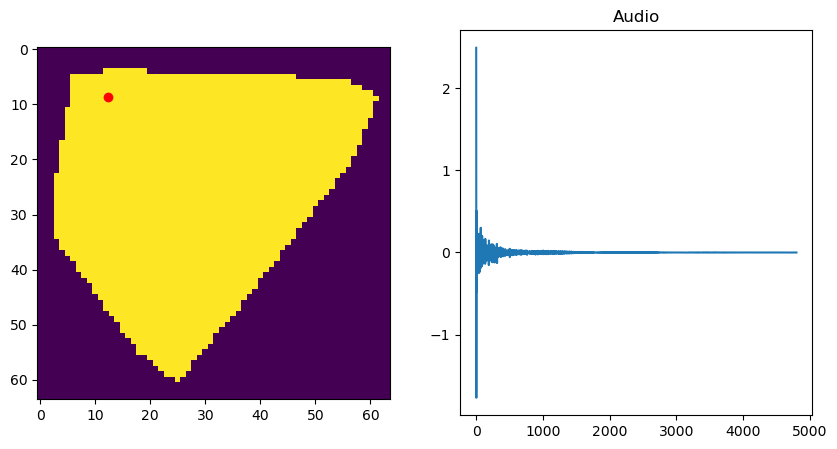

In [ ]:
sr = 16000
dataset = MultiShapeMultiMaterialDataset(
    Path("data/index_map.csv"),
    sample_rate=sr,
)
data = dataset[np.random.choice(len(dataset))]

mask = data["mask"]
scaled_coords = data["coords"] * mask.shape[1]
material = data["material_params"]
audio = data["audio"]
print(audio.shape)
print(f"Material: {material}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask[0])
ax[0].scatter(scaled_coords[0], scaled_coords[1], c="r")
ax[1].plot(audio)
ax[1].set_title("Audio")
plt.show()

save_and_display_audio(audio, f"dataload.wav", sr)


## Data module

In [ ]:
# | export

class MultiShapeMultiMaterialDataModule(pl.LightningDataModule):
    """
    A data module for the MultiShapeMultiMaterialDataset
    """

    def __init__(
        self,
        train_index_map_path: Union[Path, str],  # Directory containing training data
        val_index_map_path: Union[Path, str],  # Directory containing validation data
        test_index_map_path: Union[Path, str],  # Directory containing test data
        audio_length_in_seconds: float = 0.3,  # Length of audio to render
        sample_rate: int = 16000,  # Sample rate of audio to render
        material_ranges: MaterialRanges = MaterialRanges(), # Ranges of material parameters
        batch_size: int = 1, # Batch size
        num_workers: int = 0, # Number of workers for data loading
        pin_memory: bool = False, # Whether to pin memory for data loading
    ) -> None:
        super().__init__()

        Material.set_default_ranges(material_ranges)

        self.audio_length_in_seconds = audio_length_in_seconds
        self.sample_rate = sample_rate
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.train_index_map_path = train_index_map_path
        self.val_index_map_path = val_index_map_path
        self.test_index_map_path = test_index_map_path

    def setup(
        self,
        stage: Optional[str] = None,
    ) -> None:
        self.train_dataset = MultiShapeMultiMaterialDataset(
            index_map_path=Path(self.train_index_map_path),
            audio_length_in_seconds=self.audio_length_in_seconds,
            sample_rate=self.sample_rate,
        )

        self.val_dataset = MultiShapeMultiMaterialDataset(
            index_map_path=Path(self.val_index_map_path),
            audio_length_in_seconds=self.audio_length_in_seconds,
            sample_rate=self.sample_rate,
        )

        self.test_dataset = MultiShapeMultiMaterialDataset(
            index_map_path=Path(self.test_index_map_path),
            audio_length_in_seconds=self.audio_length_in_seconds,
            sample_rate=self.sample_rate,
        )

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
        )

    def predict_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
        )


Create a data module

In [ ]:
dataset_args = dict(
    audio_length_in_seconds=0.3,
    sample_rate=16000,
)

datamodule = MultiShapeMultiMaterialDataModule(
    train_index_map_path="data/index_map.csv",
    val_index_map_path="data/index_map.csv",
    test_index_map_path="data/index_map.csv",
)
